In [69]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [70]:
train_df = pd.read_csv("Dataset/train.csv", sep=" ", engine='python')
test_df = pd.read_csv("Dataset/test.csv", sep=" ", engine='python')

Amount Paid skew: 220.34


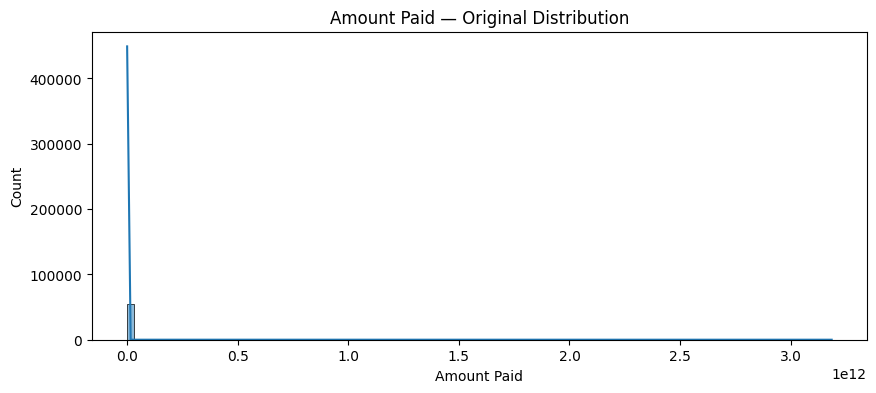

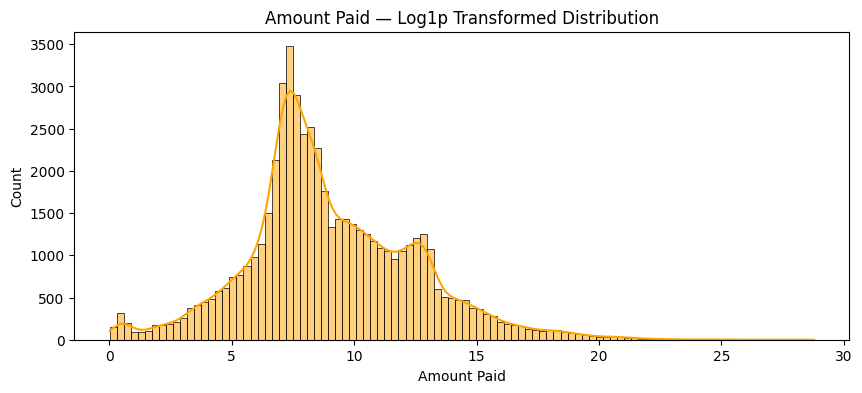

Avg Stock Account From skew: 228.12


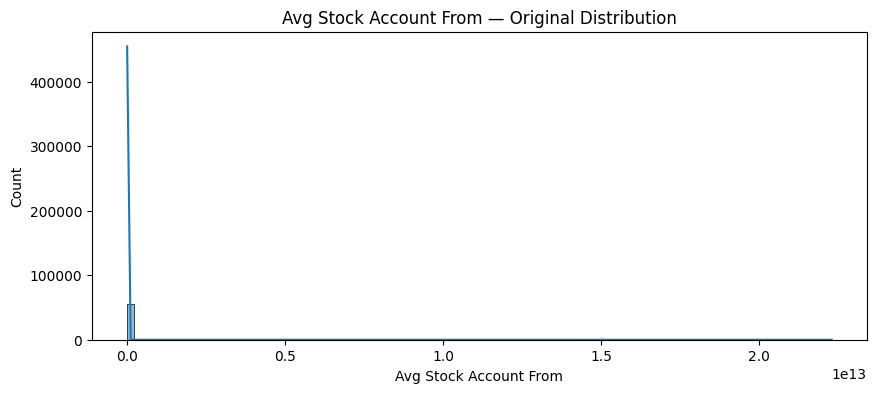

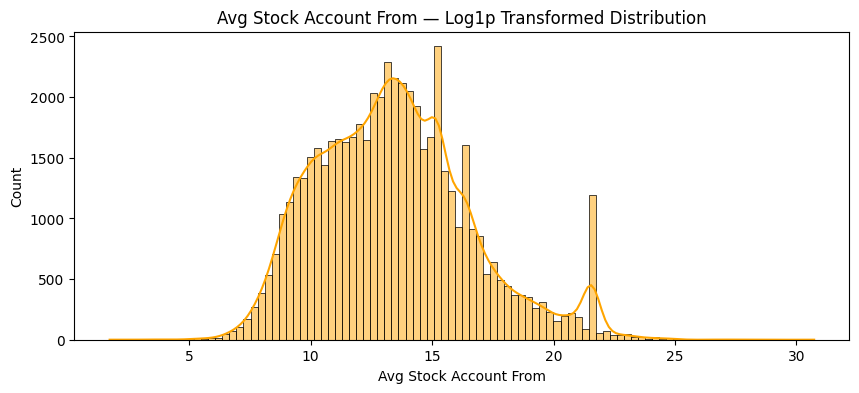

Avg Stock Account To skew: 86.40


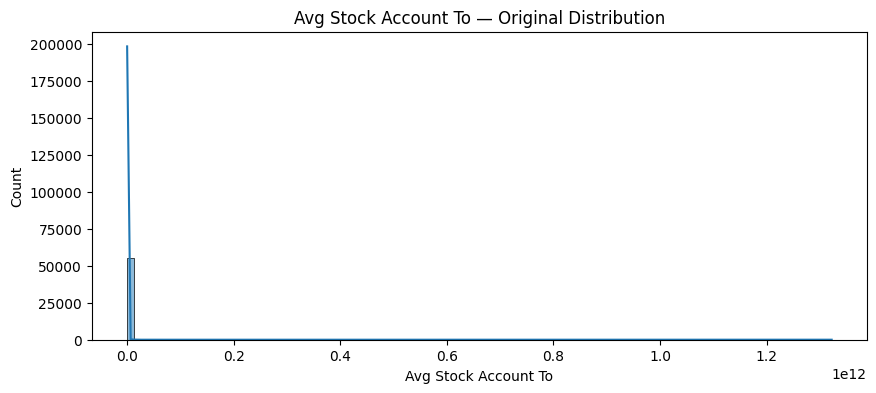

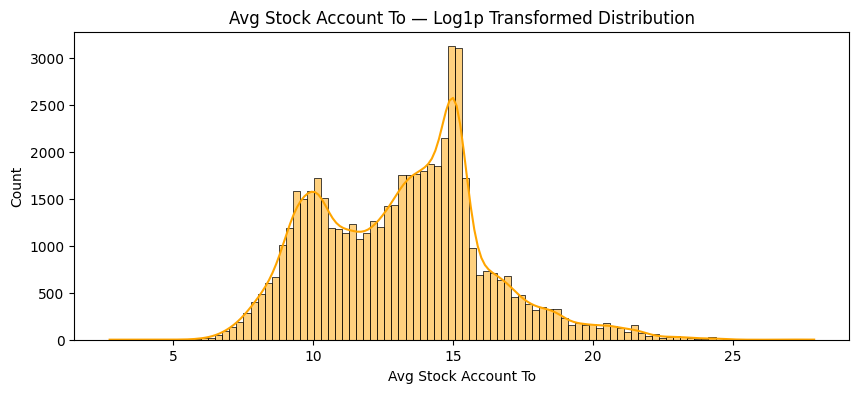

In [71]:
# List of numeric columns
num_cols = ['Amount Paid', 'Avg Stock Account From', 'Avg Stock Account To']

# Check skewness and plot
for col in num_cols:
    print(f"{col} skew: {train_df[col].skew():.2f}")
    
    # Plot original
    plt.figure(figsize=(10, 4))
    sns.histplot(train_df[col], bins=100, kde=True)
    plt.title(f"{col} — Original Distribution")
    plt.show()

    # Plot log1p
    plt.figure(figsize=(10, 4))
    sns.histplot(np.log1p(train_df[col]), bins=100, kde=True, color='orange')
    plt.title(f"{col} — Log1p Transformed Distribution")
    plt.show()


In [72]:
# Apply log1p (log(x + 1)) to avoid log(0)
train_df['Amount Paid_log'] = np.log1p(train_df['Amount Paid'])
train_df['Avg Stock Account From_log'] = np.log1p(train_df['Avg Stock Account From'])
train_df['Avg Stock Account To_log'] = np.log1p(train_df['Avg Stock Account To'])

In [73]:
test_df['Amount Paid_log'] = np.log1p(test_df['Amount Paid'])
test_df['Avg Stock Account From_log'] = np.log1p(test_df['Avg Stock Account From'])
test_df['Avg Stock Account To_log'] = np.log1p(test_df['Avg Stock Account To'])

In [74]:
# remove original columns
train_df.drop(columns=num_cols, inplace=True)
test_df.drop(columns=num_cols, inplace=True)

In [75]:
# 1. Count unique account types used by each ID when acting as From
from_types_per_id = train_df.groupby('From Account')['Type Account From'].nunique()
from_types_per_id.name = 'Num_diff_Types_As_From'

# 2. Count unique account types used by each ID when acting as To
to_types_per_id = train_df.groupby('To Account')['Type Account To'].nunique()
to_types_per_id.name = 'Num_diff_Types_As_To'

# 3. Combine both into a single DataFrame
account_type_usage = pd.concat([from_types_per_id, to_types_per_id], axis=1).fillna(0).astype(int)

In [76]:
from_types_per_id_test = test_df.groupby('From Account')['Type Account From'].nunique()
to_types_per_id_test = test_df.groupby('To Account')['Type Account To'].nunique()
account_type_usage = pd.concat([from_types_per_id_test, to_types_per_id_test], axis=1).fillna(0).astype(int)

In [77]:
# -------- FROM ACCOUNT STATS --------
from_txn_count = train_df.groupby('From Account').size().rename('From_Total_Txns')
from_unique_to = train_df.groupby('From Account')['To Account'].nunique().rename('From_Unique_Connected_To')

from_stats = pd.concat([from_unique_to], axis=1).reset_index().rename(columns={'From Account': 'Account'})

# Merge into train_df
train_df = train_df.merge(from_stats, how='left', left_on='From Account', right_on='Account')
train_df.drop(columns=['Account'], inplace=True)

# -------- TO ACCOUNT STATS --------
to_txn_count = train_df.groupby('To Account').size().rename('To_Total_Txns')
to_unique_from = train_df.groupby('To Account')['From Account'].nunique().rename('To_Unique_Connected_From')

to_stats = pd.concat([to_unique_from], axis=1).reset_index().rename(columns={'To Account': 'Account'})

# Merge into train_df
train_df = train_df.merge(to_stats, how='left', left_on='To Account', right_on='Account')
train_df.drop(columns=['Account'], inplace=True)

In [78]:
from_txn_count_test = test_df.groupby('From Account').size().rename('From_Total_Txns')
from_unique_to_test = test_df.groupby('From Account')['To Account'].nunique().rename('From_Unique_Connected_To')

from_stats_test = pd.concat([from_unique_to_test], axis=1).reset_index().rename(columns={'From Account': 'Account'})

# Merge into test_df
test_df = test_df.merge(from_stats_test, how='left', left_on='From Account', right_on='Account')
test_df.drop(columns=['Account'], inplace=True)

# -------- TO ACCOUNT STATS --------
to_txn_count_test = test_df.groupby('To Account').size().rename('To_Total_Txns')
to_unique_from_test = test_df.groupby('To Account')['From Account'].nunique().rename('To_Unique_Connected_From')

to_stats_test = pd.concat([to_unique_from_test], axis=1).reset_index().rename(columns={'To Account': 'Account'})

# Merge into test_df
test_df = test_df.merge(to_stats_test, how='left', left_on='To Account', right_on='Account')
test_df.drop(columns=['Account'], inplace=True)

### Categorical Columns to Encode

In [79]:
# One-hot encode with drop_first=True to avoid dummy trap
payment_dummies = pd.get_dummies(train_df['Payment Type'], prefix='PaymentType', drop_first=True)
from_type_dummies = pd.get_dummies(train_df['Type Account From'], prefix='FromType', drop_first=True)
to_type_dummies = pd.get_dummies(train_df['Type Account To'], prefix='ToType', drop_first=True)

# Concatenate back to train_df
train_df = pd.concat([train_df, payment_dummies, from_type_dummies, to_type_dummies], axis=1)

In [80]:
payment_dummies = pd.get_dummies(test_df['Payment Type'], prefix='PaymentType', drop_first=True)
from_type_dummies = pd.get_dummies(test_df['Type Account From'], prefix='FromType', drop_first=True)
to_type_dummies = pd.get_dummies(test_df['Type Account To'], prefix='ToType', drop_first=True)

# Concatenate back to test_df
test_df = pd.concat([test_df, payment_dummies, from_type_dummies, to_type_dummies], axis=1)

In [81]:
train_df.drop(['Payment Type', 'Type Account From', 'Type Account To'], axis=1, inplace=True)

In [82]:
test_df.drop(['Payment Type', 'Type Account From', 'Type Account To'], axis=1, inplace=True)

In [83]:
train_df.columns

Index(['Is Laundering', 'From Account', 'To Account', 'Amount Paid_log',
       'Avg Stock Account From_log', 'Avg Stock Account To_log',
       'From_Unique_Connected_To', 'To_Unique_Connected_From',
       'PaymentType_Cash', 'PaymentType_Cheque', 'PaymentType_Credit Card',
       'PaymentType_Wire', 'FromType_B', 'FromType_C', 'FromType_D',
       'FromType_E', 'FromType_F', 'ToType_B', 'ToType_C', 'ToType_D',
       'ToType_E', 'ToType_F'],
      dtype='object')

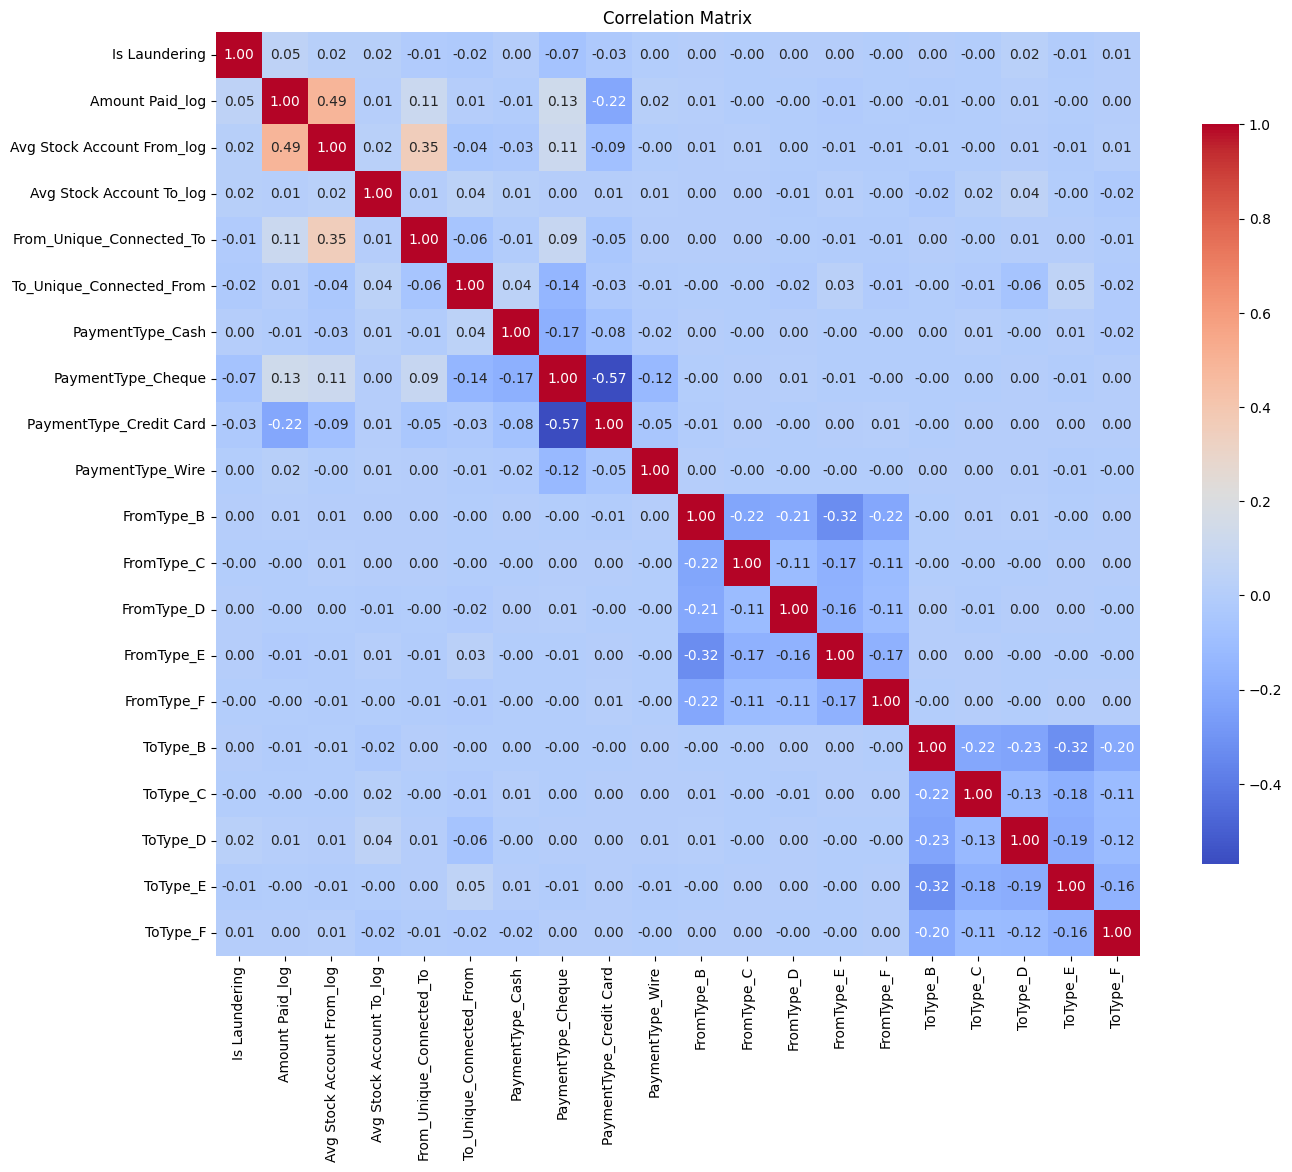

In [84]:
# correlation matrix
# create var without from and to account
train_df_no_accounts = train_df.drop(columns=['From Account', 'To Account'])

plt.figure(figsize=(16, 12))
sns.heatmap(train_df_no_accounts.corr(), annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title("Correlation Matrix")
plt.show()

In [85]:
# save to csv
train_df.to_csv("Dataset/train_processed.csv", index=False)
test_df.to_csv("Dataset/test_processed.csv", index=False)
